In [212]:
%matplotlib inline
import numpy as np
import random
from scipy import fftpack
import os, sys
import pandas as pd
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt

In [173]:
def random_map(masked_kappa, reso =4.5, size = 256):
    
    while 1==1:
        proposal = hp.gnomview(masked_kappa, rot=[30.0,30., np.random.uniform(0,180)],
                    title='example', reso=4.5, xsize=size, ysize=size,
                    flip ='geo', return_projected_map =True)
        plt.close()
        print(proposal.shape)
        if len(np.where((proposal.mask).flatten()==True)[0])>1:
            print('boundary error')
        else:
            print('boundaries good')
            break
            
    return proposal.data

def kaiser_squires_square_maps(g1, g2):
    
    size = len(g1)
    
    g1_ft = fftpack.fft2(g1)
    g2_ft = fftpack.fft2(g2)
    
    k_modes = fftpack.fftfreq(size)
    
    k1_grid = np.dstack(np.meshgrid(k_modes, k_modes))[:,:,0]
    k2_grid = k1_grid.T # k2 are transpose of k1 for square maps
    
    k1_squared = k1_grid**2
    k2_squared = k2_grid**2
    k_squared = k1_squared + k2_squared

    k_squared[k_squared==0] = 1e-18
    
    kappaE_ft = (g1_ft/k_squared)*(k1_squared-k2_squared) + (g2_ft/k_squared)*2*(k1_grid*k2_grid)
    kappaB_ft = (-1.0*g1_ft/k_squared)*2.0*(k1_squared*k2_squared) + (g2_ft/k_squared)*(k1_squared-k2_squared)

    return fftpack.ifft2(kappaE_ft).real, fftpack.ifft2(kappaB_ft).real


def make_healpix_map(ra, dec, weights, nside):
    pixels= hp.ang2pix(nside,theta = 0.5*np.pi - np.deg2rad(dec), phi = np.deg2rad(ra))
    bincount = np.bincount(pixels, minlength = hp.nside2npix(nside))
    bincount_weighted = np.bincount(pixels, minlength = hp.nside2npix(nside), weights=weights)
    return np.where(bincount>0.5, bincount_weighted/bincount, hp.UNSEEN)

def shape_noise_realisation(ra, dec, e1_orig, e2_orig, nside):
    gamma1_shuffle = np.copy(e1_orig)
    gamma2_shuffle = np.copy(e2_orig)
    random.shuffle(gamma1_shuffle)
    random.shuffle(gamma2_shuffle)
    e1_noise = make_healpix_map(ra, dec, gamma1_shuffle, nside)
    e2_noise = make_healpix_map(ra, dec, gamma2_shuffle, nside)
    return e1_noise, e2_noise
    
    

In [3]:
picola_example = hp.read_map('picola_training/kappaC_rescaled.fits')

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


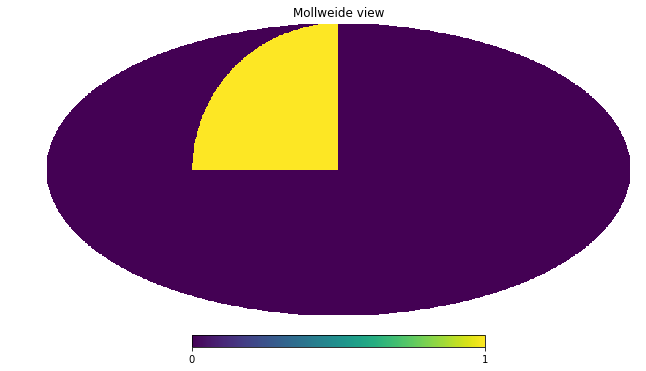

In [4]:
reduced_nside = 1024

msk=np.zeros(hp.nside2npix(reduced_nside))
th,ph=hp.pix2ang(reduced_nside,np.arange(hp.nside2npix(reduced_nside)))
ph[np.where(ph>np.pi)[0]]-=2*np.pi
msk[np.where((th<np.pi*0.5) & (ph>0) & (ph<np.pi*0.5))[0]]=1.
hp.mollview(msk)

In [5]:
picola_example_masked = np.where(msk>0.5, picola_example, hp.UNSEEN)

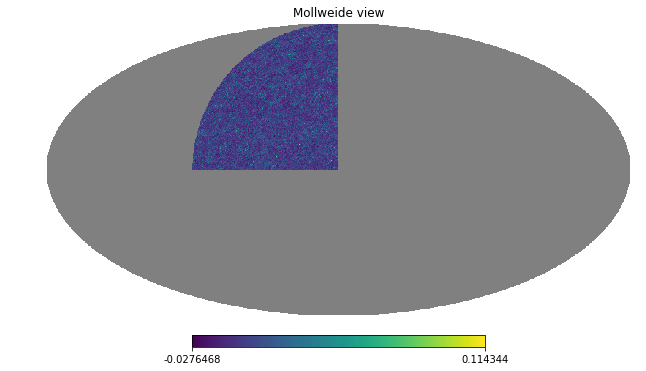

In [6]:
hp.mollview(picola_example_masked)

In [7]:
patch = random_map(picola_example_masked)

(256, 256)
boundaries good


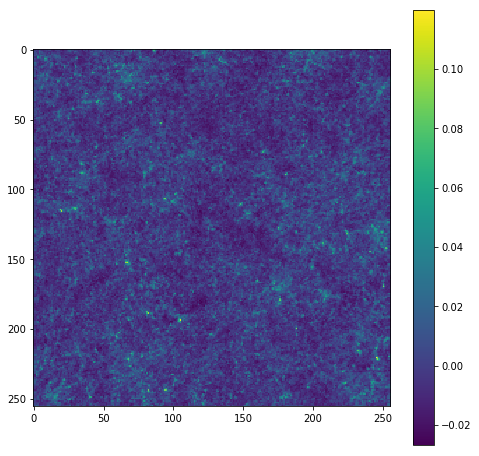

In [8]:
_ =plt.figure(figsize=(8,8)), plt.imshow(patch), plt.colorbar()

# Convert to e1 and e2

In [158]:
k_modes = fftpack.fftfreq(patch.shape[0])
k1_grid = np.dstack(np.meshgrid(k_modes, k_modes))[:,:,0]
k2_grid = k1_grid.T 

k1_vector = np.reshape(k1_grid, -1)
k2_vector = np.reshape(k2_grid, -1)

k_squared = k1_vector*k1_vector + k2_vector*k2_vector
k_squared2 = np.where(k_squared==0, 1e-18, k_squared)

A_inverse_ft_diagonal = (k1_vector**2 - k2_vector**2 - 1j*2.0*k1_vector*k2_vector)/k_squared2
A_inverse_ft_diagonal = np.where(k_squared!=0.0, A_inverse_ft_diagonal, 1.0)

A_ft_diagonal = (k1_vector**2 - k2_vector**2 + 1j*2.0*k1_vector*k2_vector)/k_squared2
A_ft_diagonal = np.where(k_squared!=0.0, A_ft_diagonal, 1.0)

In [169]:
shear_ft = A_ft_diagonal * (np.fft.fft2(patch).flatten())

shear = np.fft.ifft2(np.reshape(shear_ft, patch.shape))

g1 = shear.real
g2 = shear.imag

patch_test = np.fft.ifft2(np.reshape(A_inverse_ft_diagonal * shear_ft, patch.shape))

patch_test2 = kaiser_squires_square_maps(g1, g2) # old & different KS numerical implementation



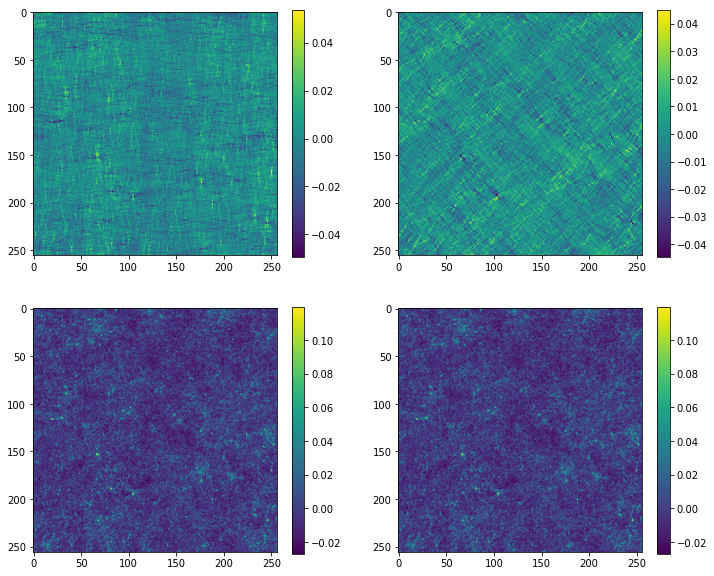

In [170]:
_ = plt.figure(figsize =(12,10))
_ = plt.subplot(2,2,1)
_ = plt.imshow(g1), plt.colorbar()
_ = plt.subplot(2,2,2)
_ = plt.imshow(g2), plt.colorbar()
_ = plt.subplot(2,2,3)
_ = plt.imshow(patch_test.real), plt.colorbar()
_ = plt.subplot(2,2,4)
_ = plt.imshow(patch), plt.colorbar()

# Add mask and noise

In [171]:
input_file_des = 'mice_mock/cat_DES_SV_zmean_final.fits'
hdu_des =  fits.open(input_file_des)
print(hdu_des.info())
des_cat = hdu_des[1].data
print(des_cat.columns)

Filename: mice_mock/cat_DES_SV_zmean_final.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   1628663R x 9C   [D, D, D, D, D, D, D, D, D]   
None
ColDefs(
    name = 'ra_gal'; format = 'D'
    name = 'dec_gal'; format = 'D'
    name = 'zmean'; format = 'D'
    name = 'e1_gal'; format = 'D'
    name = 'e2_gal'; format = 'D'
    name = 'e1_gal_sens'; format = 'D'
    name = 'e2_gal_sens'; format = 'D'
    name = 'coad_id'; format = 'D'
    name = 'sens_avg'; format = 'D'
)


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


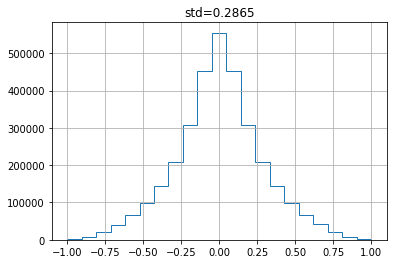

In [172]:
des_galaxy_shapes = np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')])
std_e1 = np.std(des_galaxy_shapes)
_ = plt.hist(np.concatenate([des_cat.field('e1_gal_sens'),des_cat.field('e2_gal_sens')]),
             histtype='step', bins=np.linspace(-1,1,22))
title = str('std=' + str(std_e1)[:6])
_ = plt.title(title), plt.grid('True')

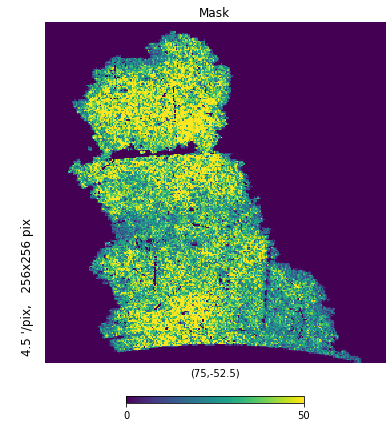

In [176]:
pixels= hp.ang2pix(reduced_nside,theta = 0.5*np.pi - np.deg2rad(des_cat.field('dec_gal')),
                   phi = np.deg2rad(des_cat.field('ra_gal')))
count_map = np.bincount(pixels, minlength = hp.nside2npix(reduced_nside))
count_gnomview= hp.gnomview(count_map, rot=[+75.0,-52.5],  title='Mask', 
                min = 0, max=50, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)


In [186]:
sv_mask = np.where(count_gnomview<1,0.,1.)

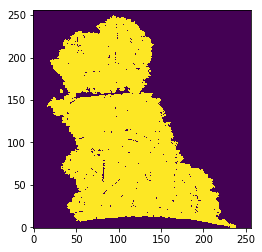

In [189]:
plt.imshow(sv_mask, origin = 'lower')

In [190]:
g1_masked = sv_mask*g1
g2_masked = sv_mask*g2

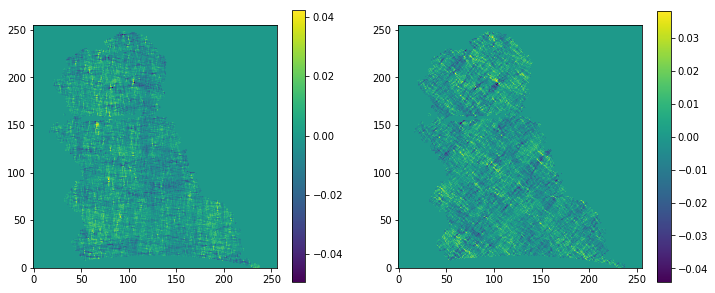

In [193]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(g1_masked, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(g2_masked, origin='lower'), plt.colorbar()

In [195]:
e1_des_noise, e2_des_noise = shape_noise_realisation(des_cat.field('ra_gal'),
                                                     des_cat.field('dec_gal'),
                                                     des_cat.field('e1_gal_sens'),
                                                     des_cat.field('e2_gal_sens'),
                                                     reduced_nside)


/Users/ucapnje/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/ucapnje/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [198]:
e1_noise_map = hp.gnomview(e1_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

e2_noise_map = hp.gnomview(e2_des_noise, rot=[+75.0,-52.5],  title='Mask', 
                min = -.2, max=.2, reso=4.5, xsize=256, ysize=256, flip ='geo', return_projected_map =True)
_ = plt.close()

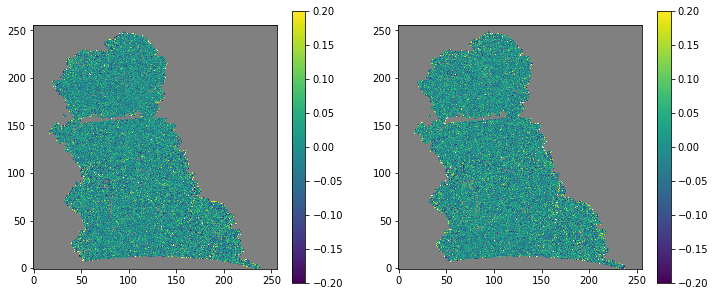

In [201]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noise_map, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

In [205]:
e1_noise_map

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-1.6375e+30)

In [206]:
e1_noisy = np.where(e1_noise_map.mask==False,  e1_noise_map + g1, 0.)
e2_noisy = np.where(e2_noise_map.mask==False,  e2_noise_map + g2, 0.)

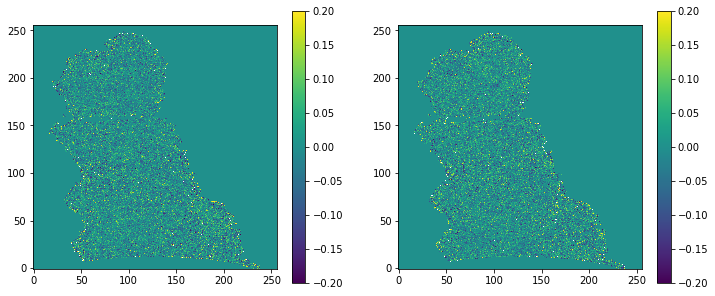

In [207]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(e1_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(e2_noisy, origin='lower', clim = (-0.2,0.2)), plt.colorbar()

# Try KS

In [208]:
ks_ft = A_inverse_ft_diagonal * (np.fft.fft2(e1_noisy + 1j*e2_noisy).flatten())

In [210]:
ks_test = np.fft.ifft2(np.reshape(ks_ft, patch.shape))

In [224]:
ks_test.real.min()

-0.3694865195732111

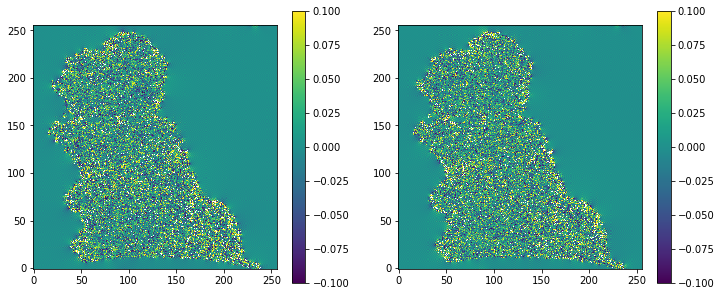

In [214]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_test.real, origin='lower', clim = (-0.1,0.1)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(ks_test.imag, origin='lower', clim = (-0.1,0.1)), plt.colorbar()

In [218]:
ks_smoothed_e = ndimage.gaussian_filter(ks_test.real, sigma=2.)
ks_smoothed_b = ndimage.gaussian_filter(ks_test.imag, sigma=2.)
patch_smoothed = ndimage.gaussian_filter(patch, sigma=2.)


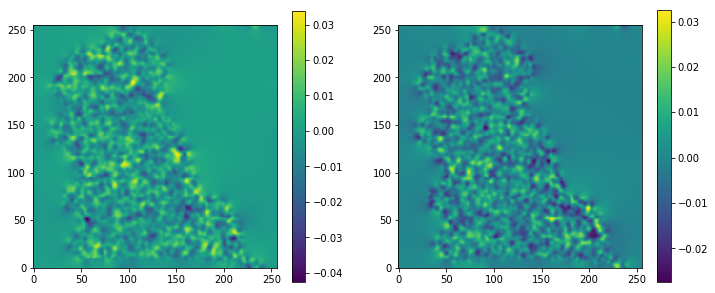

In [226]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed_e, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(ks_smoothed_b, origin='lower'), plt.colorbar()

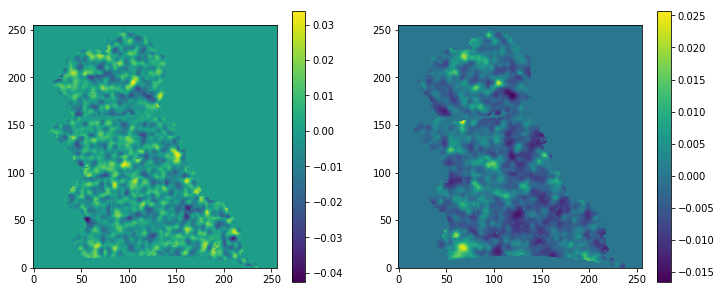

In [228]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed_e*sv_mask, origin='lower'), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(patch_smoothed*sv_mask, origin='lower'), plt.colorbar()